In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
#!pip install catboost
!pip install category_encoders
#!pip install feature_engine
#!pip install featuretools
#!pip install woodwork

#import lightgbm as lgb
import xgboost as xgb
#from catboost import *
#import catboost as ctb
#from catboost import Pool
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error
from sklearn.metrics import f1_score, accuracy_score

from sklearn import preprocessing
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler
#from feature_engine.encoding import WoEEncoder
#import featuretools as ft
#from woodwork.logical_types import Categorical

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.7 MB/s eta 0:00:00


In [5]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test.csv"))
card = pd.read_csv(os.path.join(INPUT_DIR, "card.csv"))
user = pd.read_csv(os.path.join(INPUT_DIR, "user.csv"))
sub = pd.read_csv(os.path.join(INPUT_DIR, "sample_submit.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(card.shape)
display(card.head(3))

print(user.shape)
display(user.head(3))

print(sub.shape)
display(sub.head(3))

(471283, 12)


,index,user_id,card_id,amount,errors?,is_fraud?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,0,1721,0,$2.623,OK,0,209237,Joliet,IL,60436.0,5541,Swipe Transaction
1,1,1629,3,$6.4,OK,0,2568,Edgerton,WI,53534.0,5814,Swipe Transaction
2,2,655,3,$123.5,OK,0,345310,Ridgefield,WA,98642.0,7538,Swipe Transaction


(457958, 11)


,index,user_id,card_id,amount,errors?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,471283,541,3,$113.278,OK,324189,Orlando,FL,32821.0,4814,Swipe Transaction
1,471284,655,1,$293.944,OK,81219,Ridgefield,WA,98642.0,7538,Chip Transaction
2,471285,492,0,$47.4,OK,274755,Arlington Heights,IL,60004.0,5719,Swipe Transaction


(416, 10)


,user_id,card_id,card_brand,card_type,expires,has_chip,cards_issued,credit_limit,acct_open_date,year_pin_last_changed
0,39,0,Visa,Debit,09/2021,YES,1,$17117,05/2007,2010
1,39,1,Amex,Credit,11/2024,YES,2,$5400,10/2015,2015
2,41,0,Discover,Credit,03/2022,YES,2,$14800,12/2010,2011


(97, 17)


,user_id,current_age,retirement_age,birth_year,birth_month,gender,address,city,state,zipcode,latitude,longitude,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards
0,39,57,64,1962,12,Female,442 Burns Boulevard,Mansfield,MA,2048,42.02,-71.21,$37407,$76274,$102611,698,2
1,41,39,66,1980,10,Female,3863 River Avenue,Lincoln,CA,95648,38.93,-121.25,$21829,$44506,$57994,849,3
2,47,40,67,1979,5,Female,8799 Elm Avenue,Mckinney,TX,75069,33.20,-96.65,$24684,$50329,$76759,625,4


(457958, 2)


,0,1
0,471283,0
1,471284,1
2,471285,0


In [6]:
train["amount"] = train["amount"].astype(str).str.extract("(\d+)").astype("float32")
test["amount"] = test["amount"].astype(str).str.extract("(\d+)").astype("float32")

In [7]:
concat_data = pd.concat([train,test],axis=0)

concat_data = concat_data.fillna("NAN")

city_c = concat_data["merchant_city"].value_counts(normalize=True).to_dict()
state_c = concat_data["merchant_state"].value_counts(normalize=True).to_dict()

concat_data["city_c"] = concat_data["merchant_city"].map(lambda x: city_c[x]).values
concat_data["state_c"] = concat_data["merchant_state"].map(lambda x: state_c[x]).values

concat_data.loc[concat_data["city_c"]<0.0005, "merchant_city"] = "Rare_city"
concat_data.loc[concat_data["state_c"]<0.0005, "merchant_state"] = "Rare_state"

concat_data = concat_data.merge(card, how="left", on=["user_id", "card_id"]).merge(user, how="left", on="user_id")

In [8]:
for col in ["errors?", "merchant_city", "merchant_state", "use_chip", "card_brand", "card_type", "has_chip", "gender", "city", "state"]:
  print(col)
  le = preprocessing.LabelEncoder()
  le.fit(concat_data[col])
  concat_data[col] = le.transform(concat_data[col])

errors?
merchant_city
merchant_state
use_chip
card_brand
card_type
has_chip
gender
city
state


In [9]:
concat_data["credit_limit"] = concat_data["credit_limit"].astype(str).str.extract("(\d+)").astype("float32")
concat_data["per_capita_income_zipcode"] = concat_data["per_capita_income_zipcode"].astype(str).str.extract("(\d+)").astype("float32")
concat_data["yearly_income_person"] = concat_data["yearly_income_person"].astype(str).str.extract("(\d+)").astype("float32")
concat_data["total_debt"] = concat_data["total_debt"].astype(str).str.extract("(\d+)").astype("float32")

In [10]:
concat_data["income_rate"] = concat_data["yearly_income_person"] / concat_data["per_capita_income_zipcode"]

In [11]:
train_df = concat_data.iloc[:train.shape[0],:]
train_df = train_df.reset_index(drop=True)
test_df = concat_data.iloc[train.shape[0]:,:]
test_df = test_df.reset_index(drop=True)

In [12]:
amount_user_mean = train_df.groupby("user_id")["amount"].mean().to_dict()
train_df["amount_mean"] = train_df["user_id"].map(lambda x: amount_user_mean[x]).values
test_df["amount_mean"] = test_df["user_id"].map(lambda x: amount_user_mean[x]).values
train_df["diff_amount"] = train_df["amount"] - train_df["amount_mean"]
test_df["diff_amount"] = test_df["amount"] - test_df["amount_mean"]

In [13]:
numerical_features = ["amount", "cards_issued", "credit_limit", "current_age", "retirement_age", "birth_year", "latitude", "longitude",
                      "per_capita_income_zipcode", "yearly_income_person", "total_debt", "fico_score", "num_credit_cards", "income_rate"]
categorical_features = ["user_id", "card_id", "errors?", "merchant_id", "merchant_city", "merchant_state", "mcc", "use_chip",
                        "card_brand", "card_type", "has_chip", "gender", "city", "state",
                        "birth_month",
                        ]
target = "is_fraud?"

In [14]:
train_df["neg_is_franud?"] = pd.Series(np.where(train_df[target]==1.0, 0.0, 1.0))
total_pos = train_df[target].sum()
total_neg = train_df["neg_is_franud?"].sum()

for col in categorical_features:
  print(col)
  if col=="merchant_id":
    continue
  pos = train_df.groupby(col)[target].sum() / total_pos
  neg = train_df.groupby(col)["neg_is_franud?"].sum() / total_neg
  woe = pos/neg
  train_df[f"{col}_woe"] = np.log(train_df[col].map(woe).astype(float))
  test_df[f"{col}_woe"] = np.log(test_df[col].map(woe).astype(float))

user_id
card_id
errors?
merchant_id
merchant_city
merchant_state
mcc


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


use_chip
card_brand
card_type
has_chip
gender
city
state
birth_month


In [15]:
train_df[target] = train_df[target].astype(float)
corr_list = [target] + numerical_features + [f"{col}_woe" for col in categorical_features if col not in "merchant_id"] + ["diff_amount", "amount_mean"]
train_df[corr_list].corr()

,is_fraud?,amount,cards_issued,credit_limit,current_age,retirement_age,birth_year,latitude,longitude,per_capita_income_zipcode,...,use_chip_woe,card_brand_woe,card_type_woe,has_chip_woe,gender_woe,city_woe,state_woe,birth_month_woe,diff_amount,amount_mean
is_fraud?,1.000000,0.149597,-0.007397,-0.025715,-1.293722e-02,-1.767451e-02,1.343035e-02,1.110763e-02,2.455224e-03,-1.910162e-02,...,0.225278,0.030054,0.024515,0.023347,1.718270e-02,9.122139e-02,4.238608e-02,4.611272e-02,1.580650e-01,-1.643982e-02
amount,0.149597,1.000000,-0.037866,0.084524,2.313861e-02,-3.010743e-02,-2.304187e-02,-2.820779e-03,-4.132371e-02,1.547977e-01,...,0.083184,0.010130,0.001320,0.012968,-1.973489e-02,-2.253464e-02,-5.641419e-02,-5.083988e-02,9.712044e-01,2.382478e-01
cards_issued,-0.007397,-0.037866,1.000000,-0.064020,-4.452398e-02,-1.809705e-02,4.397551e-02,6.063400e-02,-2.394917e-02,-5.224915e-03,...,-0.017527,-0.072797,0.013158,0.015306,-7.593239e-02,1.362764e-02,-2.117442e-02,2.932613e-02,-2.971864e-02,-3.779098e-02
credit_limit,-0.025715,0.084524,-0.064020,1.000000,-8.035226e-02,6.515193e-03,8.095576e-02,9.285560e-02,-7.388929e-02,4.400206e-01,...,0.006417,-0.141868,-0.459051,-0.034776,1.543861e-02,-3.262422e-02,4.399991e-02,-5.550532e-02,1.755220e-02,2.832226e-01
current_age,-0.012937,0.023139,-0.044524,-0.080352,1.000000e+00,1.948660e-02,-9.997259e-01,-1.241548e-01,3.179932e-02,-8.371600e-03,...,-0.000593,-0.099158,0.057243,-0.020377,-4.432176e-02,-1.499338e-01,-1.205216e-01,3.451694e-02,2.424547e-09,9.711994e-02
retirement_age,-0.017675,-0.030107,-0.018097,0.006515,1.948660e-02,1.000000e+00,-2.124429e-02,6.156376e-02,7.915272e-02,-1.191592e-01,...,0.008893,-0.023159,-0.025785,-0.031450,-1.911920e-02,-1.770961e-01,-3.497410e-02,7.625623e-03,-6.643947e-10,-1.263703e-01
birth_year,0.013430,-0.023042,0.043976,0.080956,-9.997259e-01,-2.124429e-02,1.000000e+00,1.249703e-01,-2.948737e-02,5.640238e-03,...,0.001345,0.100585,-0.058511,0.019226,4.441595e-02,1.525214e-01,1.245887e-01,-2.517494e-02,-2.437178e-09,-9.671389e-02
latitude,0.011108,-0.002821,0.060634,0.092856,-1.241548e-01,6.156376e-02,1.249703e-01,1.000000e+00,3.850207e-02,7.869494e-02,...,-0.008528,-0.021290,-0.076998,-0.052635,1.272497e-01,1.337622e-01,2.694811e-01,6.987778e-02,-1.214072e-09,-1.183968e-02
longitude,0.002455,-0.041324,-0.023949,-0.073889,3.179932e-02,7.915272e-02,-2.948737e-02,3.850207e-02,1.000000e+00,-2.289462e-01,...,-0.003158,0.057189,-0.054855,0.053170,-2.471657e-02,2.444905e-02,4.881645e-02,6.157512e-03,1.639091e-09,-1.734485e-01
per_capita_income_zipcode,-0.019102,0.154798,-0.005225,0.440021,-8.371600e-03,-1.191592e-01,5.640238e-03,7.869494e-02,-2.289462e-01,1.000000e+00,...,0.014517,-0.073518,-0.061816,-0.039089,-2.671464e-02,-1.402008e-01,-7.465622e-02,-1.888632e-01,3.661783e-09,6.497340e-01


In [16]:
def get_target_encoder(train, valid, test):
  mean_enc = TargetEncoder(
    cols=categorical_features, min_samples_leaf=25, smoothing=1.0
  )
  mean_enc.fit(valid[categorical_features], valid[target])
  X_train_enc = mean_enc.transform(train[categorical_features])
  X_valid_enc = mean_enc.transform(valid[categorical_features])
  X_test_enc = mean_enc.transform(test[categorical_features])
  X_train_enc = X_train_enc.add_prefix('trg_')
  X_valid_enc = X_valid_enc.add_prefix('trg_')
  X_test_enc = X_test_enc.add_prefix('trg_')
  train = pd.concat([train,X_train_enc], axis=1)
  valid = pd.concat([valid,X_valid_enc], axis=1)
  test = pd.concat([test,X_test_enc], axis=1)
  return train, valid, test

In [17]:
class CFG:
  debug=False
  ver=20
  model="xgboost"
  n_folds=5
  trn_fold=[0, 1, 2, 3, 4]
  seed=42
  target= target
  boosting_type="gbdt"
  early_stopping_round=50
  verbose=200
  num_boost_round = 20000

In [18]:
skf = StratifiedKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for fold, (train_index, valid_index) in enumerate(skf.split(train_df, train_df[CFG.target])):
    train_df.loc[valid_index, "fold"] = fold
train_df['fold'] = train_df['fold'].astype(int)
display(train_df.groupby('fold').size())

fold
0    94257
1    94257
2    94257
3    94256
4    94256
dtype: int64

In [19]:
if CFG.debug:
    display(train_df.groupby('fold').size())
    train_df = train_df.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train_df.groupby('fold').size())

In [20]:
params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 5,
        "n_estimators":8000,
        #'colsample_bytree': 0.50,
        #'subsample': 0.80,
        'eta': 0.05,
        #'gamma': 1.5,
        #"enable_categorical":True,
        # 'lambda': 70,
        # 'min_child_weight': 8,
        # 'eval_metric':'logloss',
        'tree_method': 'gpu_hist',
        'predictor':'gpu_predictor',
        'seed': CFG.seed,
    }

features = numerical_features + categorical_features + [f"{col}_woe" for col in categorical_features if col not in "merchant_id"] + ["amount_mean", "diff_amount"] + [f"trg_{col}" for col in categorical_features]
oof_df = pd.DataFrame()
test_preds = np.zeros(len(test_df))

for fold in range(CFG.n_folds):
  if fold in CFG.trn_fold:
    print("="*15,f" FOLD : {fold} ","="*15)
    train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)

    train_folds, valid_folds, test_folds = get_target_encoder(train_folds, valid_folds, test_df)

    train_X = train_folds[features]
    valid_X = valid_folds[features]
    test_X = test_folds[features]
    train_labels = train_folds[CFG.target].values
    valid_labels = valid_folds[CFG.target].values

    #for col in categorical_features:
    #  train_X[col] = train_X[col].astype("category")
    #  valid_X[col] = valid_X[col].astype("category")
    #  test_X[col] = test_X[col].astype("category")

    drop_list = train_X[features].columns[np.isinf(train_X[features]).any()].tolist()
    train_X = train_X.drop(drop_list, axis=1)
    valid_X = valid_X.drop(drop_list, axis=1)
    test_X = test_X.drop(drop_list, axis=1)
    print(drop_list)

    model = xgb.XGBClassifier(**params)
    model.fit(train_X, train_labels,
              eval_set=[(train_X, train_labels), (valid_X, valid_labels)],
              early_stopping_rounds=CFG.early_stopping_round,
              verbose=CFG.verbose
              )

    valid_folds["pred"] = model.predict_proba(valid_X)[:, 1]
    test_preds += model.predict_proba(test_X)[:, 1]
    oof_df = pd.concat([oof_df, valid_folds])

    validy_pred = np.where(valid_folds["pred"]>0.5, 1, 0)
    scoref1 =  f1_score(valid_labels, validy_pred)
    print(f"F1 Score : {scoref1}")
    del model, train_folds, valid_folds, test_folds, train_X, valid_X, test_X, validy_pred

===============  FOLD : 0  ===============
['income_rate', 'merchant_city_woe']


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.65350	validation_1-logloss:0.65338
[200]	validation_0-logloss:0.14936	validation_1-logloss:0.14679
[400]	validation_0-logloss:0.14020	validation_1-logloss:0.14014
[600]	validation_0-logloss:0.13374	validation_1-logloss:0.13610
[800]	validation_0-logloss:0.12885	validation_1-logloss:0.13374
[1000]	validation_0-logloss:0.12528	validation_1-logloss:0.13235
[1200]	validation_0-logloss:0.12212	validation_1-logloss:0.13128
[1400]	validation_0-logloss:0.11908	validation_1-logloss:0.13039
[1600]	validation_0-logloss:0.11658	validation_1-logloss:0.12980
[1800]	validation_0-logloss:0.11420	validation_1-logloss:0.12938
[2000]	validation_0-logloss:0.11212	validation_1-logloss:0.12907
[2200]	validation_0-logloss:0.11011	validation_1-logloss:0.12889
[2400]	validation_0-logloss:0.10822	validation_1-logloss:0.12867
[2600]	validation_0-logloss:0.10642	validation_1-logloss:0.12845
[2763]	validation_0-logloss:0.10510	validation_1-logloss:0.12843
F1 Score : 0.6238040566398776
==

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.65366	validation_1-logloss:0.65351
[200]	validation_0-logloss:0.14979	validation_1-logloss:0.14816
[400]	validation_0-logloss:0.13966	validation_1-logloss:0.14065
[600]	validation_0-logloss:0.13345	validation_1-logloss:0.13700
[800]	validation_0-logloss:0.12897	validation_1-logloss:0.13492
[1000]	validation_0-logloss:0.12537	validation_1-logloss:0.13345
[1200]	validation_0-logloss:0.12211	validation_1-logloss:0.13222
[1400]	validation_0-logloss:0.11913	validation_1-logloss:0.13126
[1600]	validation_0-logloss:0.11665	validation_1-logloss:0.13077
[1800]	validation_0-logloss:0.11423	validation_1-logloss:0.13035
[2000]	validation_0-logloss:0.11189	validation_1-logloss:0.12993
[2200]	validation_0-logloss:0.10991	validation_1-logloss:0.12967
[2400]	validation_0-logloss:0.10813	validation_1-logloss:0.12945
[2516]	validation_0-logloss:0.10703	validation_1-logloss:0.12938
F1 Score : 0.6203507419541339
===============  FOLD : 2  ===============
['income_rate', 'merchan

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.65368	validation_1-logloss:0.65358
[200]	validation_0-logloss:0.14985	validation_1-logloss:0.14702
[400]	validation_0-logloss:0.14014	validation_1-logloss:0.13967
[600]	validation_0-logloss:0.13413	validation_1-logloss:0.13594
[800]	validation_0-logloss:0.12958	validation_1-logloss:0.13350
[1000]	validation_0-logloss:0.12579	validation_1-logloss:0.13177
[1200]	validation_0-logloss:0.12259	validation_1-logloss:0.13066
[1400]	validation_0-logloss:0.11967	validation_1-logloss:0.12979
[1600]	validation_0-logloss:0.11710	validation_1-logloss:0.12918
[1800]	validation_0-logloss:0.11478	validation_1-logloss:0.12862
[2000]	validation_0-logloss:0.11260	validation_1-logloss:0.12824
[2200]	validation_0-logloss:0.11061	validation_1-logloss:0.12802
[2400]	validation_0-logloss:0.10882	validation_1-logloss:0.12790
[2600]	validation_0-logloss:0.10704	validation_1-logloss:0.12781
[2800]	validation_0-logloss:0.10527	validation_1-logloss:0.12761
[2973]	validation_0-logloss:0.10

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.65354	validation_1-logloss:0.65345
[200]	validation_0-logloss:0.14848	validation_1-logloss:0.14769
[400]	validation_0-logloss:0.13929	validation_1-logloss:0.14141
[600]	validation_0-logloss:0.13341	validation_1-logloss:0.13787
[800]	validation_0-logloss:0.12923	validation_1-logloss:0.13594
[1000]	validation_0-logloss:0.12566	validation_1-logloss:0.13450
[1200]	validation_0-logloss:0.12231	validation_1-logloss:0.13321
[1400]	validation_0-logloss:0.11965	validation_1-logloss:0.13248
[1600]	validation_0-logloss:0.11710	validation_1-logloss:0.13184
[1800]	validation_0-logloss:0.11478	validation_1-logloss:0.13135
[2000]	validation_0-logloss:0.11266	validation_1-logloss:0.13095
[2200]	validation_0-logloss:0.11057	validation_1-logloss:0.13065
[2400]	validation_0-logloss:0.10859	validation_1-logloss:0.13036
[2600]	validation_0-logloss:0.10683	validation_1-logloss:0.13014
[2800]	validation_0-logloss:0.10508	validation_1-logloss:0.13002
[2873]	validation_0-logloss:0.10

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.65366	validation_1-logloss:0.65358
[200]	validation_0-logloss:0.14916	validation_1-logloss:0.14986
[400]	validation_0-logloss:0.13948	validation_1-logloss:0.14287
[600]	validation_0-logloss:0.13341	validation_1-logloss:0.13925
[800]	validation_0-logloss:0.12872	validation_1-logloss:0.13681
[1000]	validation_0-logloss:0.12504	validation_1-logloss:0.13528
[1200]	validation_0-logloss:0.12179	validation_1-logloss:0.13422
[1400]	validation_0-logloss:0.11899	validation_1-logloss:0.13336
[1600]	validation_0-logloss:0.11633	validation_1-logloss:0.13270
[1800]	validation_0-logloss:0.11387	validation_1-logloss:0.13212
[2000]	validation_0-logloss:0.11182	validation_1-logloss:0.13182
[2200]	validation_0-logloss:0.10977	validation_1-logloss:0.13148
[2400]	validation_0-logloss:0.10805	validation_1-logloss:0.13127
[2502]	validation_0-logloss:0.10717	validation_1-logloss:0.13125
F1 Score : 0.6132997773690834


In [21]:
f1score =  f1_score(oof_df[CFG.target], np.where(oof_df["pred"]>0.5,1,0))
print(f'CV F1 Score: {f1score}')

CV F1 Score: 0.6216117567956969


In [22]:
best_score = 0
best_thresh = 0.5
for thresh in np.arange(0.15, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(oof_df[CFG.target], (oof_df["pred"]>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score:
      best_score = score
      best_thresh = thresh
print()
print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(oof_df[CFG.target], (oof_df["pred"]>best_thresh).astype(int))))

F1 score at threshold 0.15 is 0.593523021738853
F1 score at threshold 0.16 is 0.6015748031496063
F1 score at threshold 0.17 is 0.609172187213874
F1 score at threshold 0.18 is 0.614849859998069
F1 score at threshold 0.19 is 0.6202952445345954
F1 score at threshold 0.2 is 0.6251150218541522
F1 score at threshold 0.21 is 0.629505411619971
F1 score at threshold 0.22 is 0.6325692170288776
F1 score at threshold 0.23 is 0.6354877255607824
F1 score at threshold 0.24 is 0.6381712181650813
F1 score at threshold 0.25 is 0.6401182695300341
F1 score at threshold 0.26 is 0.6419406702184672
F1 score at threshold 0.27 is 0.6425140048198924
F1 score at threshold 0.28 is 0.6439490548677138
F1 score at threshold 0.29 is 0.6446032833969777
F1 score at threshold 0.3 is 0.6451538359963027
F1 score at threshold 0.31 is 0.6446595460614153
F1 score at threshold 0.32 is 0.6449407167879277
F1 score at threshold 0.33 is 0.6451733514615908
F1 score at threshold 0.34 is 0.6448715091460802
F1 score at threshold 0.35

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0


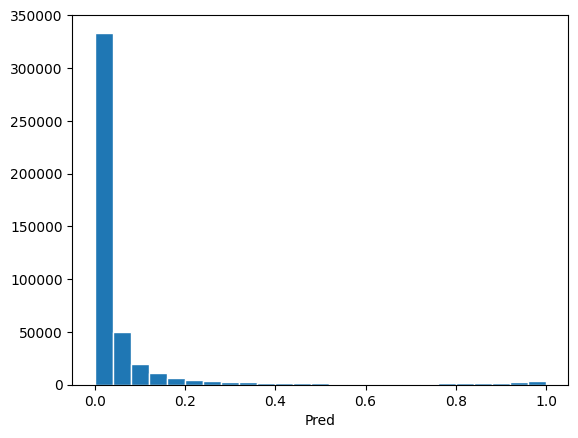

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


In [23]:
submit = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
pred = test_preds / CFG.n_folds
submit[1] = (pred>best_thresh).astype(int)

submit.to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)
display(submit.head())

plt.hist(pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(submit)

In [24]:
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')

if not os.path.exists(OOF_DIR):
    os.makedirs(OOF_DIR)

oof_df.to_csv(os.path.join(OOF_DIR, f'oof_{CFG.model}_ver{CFG.ver}.csv'))

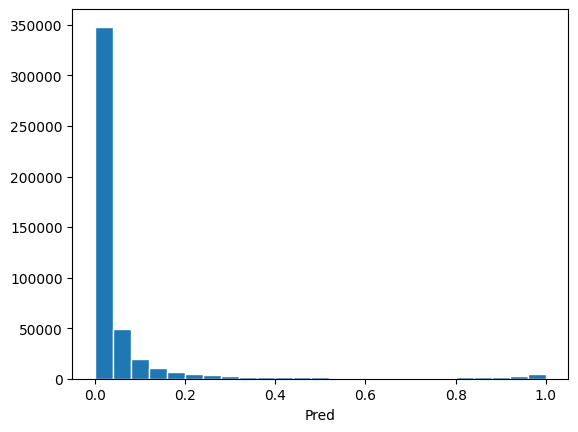

In [25]:
plt.hist(oof_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

In [26]:
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')

if not os.path.exists(SUB_NUM_DIR):
    os.makedirs(SUB_NUM_DIR)

sub_df = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
pred = test_preds / CFG.n_folds
sub_df[1] = pred

sub_df.to_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)
display(sub_df.head())

,0,1
0,471283,0.020206
1,471284,0.174519
2,471285,0.083202
3,471286,0.382325
4,471287,0.004883


In [27]:
from google.colab import runtime
runtime.unassign()